# Analysis: Air Quality vs Happiness Index

In [16]:
# Import dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as stats
from pprint import pprint

# Dependencies (local modules)
from countries import get_country

## Import both Air Quality and Happiness Index data sources
### Cleaned_Datasets
- cleaned_happiness_index.csv
- cleaned_airquality.csv

In [17]:
# Import CSV to DataFrames
csv_airquality = Path("Cleaned_Datasets/cleaned_airquality.csv")
csv_happiness = Path("Cleaned_Datasets/cleaned_happiness_index.csv")

airquality_df = pd.read_csv(csv_airquality)
happiness_df = pd.read_csv(csv_happiness)

In [18]:
# Air quality data uses a Country Code instead of country name. Use local module 'get_country' to convert to Country Name 
# Iterate through the DataFrame
for index, row in airquality_df.iterrows():
    # Replace the country code by the country name
    airquality_df.loc[index,'Country'] = get_country(airquality_df.loc[index,'Country'])

# List all the countries in the air quality DataFrame
airquality_countries = airquality_df['Country'].unique().tolist()
print(f"{len(airquality_countries)} countries found.")
pprint(airquality_countries)

93 countries found.
['United Arab Emirates',
 'Afghanistan',
 'Argentina',
 'Austria',
 'Australia',
 'Bosnia and Herzegovina',
 'Bangladesh',
 'Belgium',
 'Bulgaria',
 'Bahrain',
 'Brazil',
 'Canada',
 'Switzerland',
 "Cote d'Ivoire",
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Curaçao',
 'Cyprus',
 'Czechia',
 'Germany',
 'Denmark',
 'Algeria',
 'Ecuador',
 'Estonia',
 'Spain',
 'Ethiopia',
 'Finland',
 'France',
 'United Kingdom of Great Britain and Northern Ireland',
 'Georgia',
 'Ghana',
 'Guinea',
 'Greece',
 'Guatemala',
 'Hong Kong',
 'Croatia',
 'Hungary',
 'Indonesia',
 'Ireland',
 'Israel',
 'India',
 'Iraq',
 'Iran (Islamic Republic of)',
 'Iceland',
 'Italy',
 'Jordan',
 'Japan',
 'Kyrgyzstan',
 'Republic of Korea',
 'Kuwait',
 'Kazakhstan',
 "Lao People's Democratic Republic",
 'Sri Lanka',
 'Lithuania',
 'North Macedonia',
 'Mali',
 'Myanmar',
 'Mongolia',
 'Macao',
 'Mexico',
 'The Netherlands',
 'Norway',
 'Nepal',
 'New Zealand',
 'Peru',
 'Philippines',
 'Pakis

In [19]:
# Reformat the Happiness Index dataframe to match the format of the Air Quality dataframe

# Create a list of years from 2015 to 2019
years = [str(year) for year in range(2015, 2020)]

# Create an empty DataFrame to store the reformatted data
happiness_reformatted = pd.DataFrame()

# Iterate over the years and extract the 'Rank' and 'Score' columns for each year
for year in years:
    rank_column = 'Rank ' + year
    score_column = 'Score ' + year

    # Create a temporary DataFrame for the current year's data
    year_data = pd.DataFrame()
    year_data['Country'] = happiness_df['Country']
    year_data['Year'] = [year] * len(happiness_df)
    year_data['Rank'] = happiness_df[rank_column]
    year_data['Score'] = happiness_df[score_column]

    # Concatenate the current year's data to the reformatted DataFrame
    happiness_reformatted = pd.concat([happiness_reformatted, year_data], ignore_index=True)

# Display the reformatted 'Happiness' DataFrame
happiness_reformatted.head()


,Country,Year,Rank,Score
0,Switzerland,2015,1,7.587
1,Iceland,2015,2,7.561
2,Denmark,2015,3,7.527
3,Norway,2015,4,7.522
4,Canada,2015,5,7.427


In [20]:
# Convert the 'Year' column to a consistent data type in both DataFrames
# This conversion is necessary to ensure compatibility for merging the DataFrames later on.
airquality_df['Year'] = airquality_df['Year'].astype(str)
happiness_reformatted['Year'] = happiness_reformatted['Year'].astype(str)

In [21]:
# Drop the rows with '0' values in the 'Rank' and 'Score' columns inside the Happiness Index DF. If '0' values are present in our 'Rank' and 'Score' data, it will skew our analysis. 
happiness_reformatted = happiness_reformatted[(happiness_reformatted['Rank'] != 0) & (happiness_reformatted['Score'] != 0)]

# Reset the index of the DataFrame
happiness_reformatted = happiness_reformatted.reset_index(drop=True)

happiness_reformatted.head(10)

,Country,Year,Rank,Score
0,Switzerland,2015,1,7.587
1,Iceland,2015,2,7.561
2,Denmark,2015,3,7.527
3,Norway,2015,4,7.522
4,Canada,2015,5,7.427
5,Finland,2015,6,7.406
6,Netherlands,2015,7,7.378
7,Sweden,2015,8,7.364
8,New Zealand,2015,9,7.286
9,Australia,2015,10,7.284


## Merge DataFrames
- Merged on country and year
- Only countries and years present in both files are kept

In [22]:
# Merge the two DataFrames and keep only the countries and years that are present in both
analysis_df = pd.merge(airquality_df, happiness_reformatted, on=["Country", "Year"], how="inner")

# Sort the DataFrame by 'Year' and rest index
analysis_df = analysis_df.sort_values('Year')
analysis_df = analysis_df.reset_index(drop=True)

#show merged df head
analysis_df.head()

,Country,Year,PM25,Rank,Score
0,United Arab Emirates,2015,118.714286,20,6.901
1,Taiwan,2015,70.597296,38,6.298
2,Chile,2015,74.443741,27,6.670
3,China,2015,120.768659,84,5.140
4,Colombia,2015,74.106977,33,6.477


## Data Analysis

### Correlation between Happiness Index Rank and Air Quality (PM2.5)
Overall correlation for Air Quality(PM2.5) and Happiness Rank for all countries and all years at once.

The Dataset used for the below includes:
72 countries over 5 years worth of Happiness Index Rankings and the Air Quality (PM2.5 values) for the corresponding years.  

Note: In terms of air quality measurements, a lower PM2.5 value indicates better air quality. Lower concentrations of PM2.5 implies fewer particles in the air, which reduces the potential health risks associated with exposure. Conversely, higher PM2.5 values indicate poorer air quality with a higher concentration of fine particles, which can pose greater health risks.

Note that the classification of PM2.5 concentrations may vary slightly between different countries or organisations, but in general, air quality guidelines commonly categorize PM2.5 concentrations as follows:

**Good:** 0-12   
**Moderate:** 12.1 - 35.4   
**Unhealthy for Sensitive Groups:** 35.5 - 55.4   
**Unhealthy:** 55.5 - 150.4   
**Very Unhealthy:** 150.5 - 250.4   
**Hazardous:** 250.5+ 


R-value: 0.62
Linear model: [Rank] = 0.6884 * [PM25] + 5.84


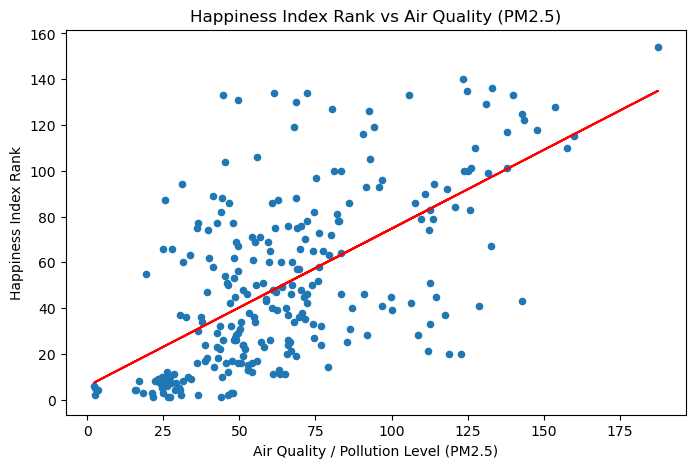

In [23]:
# Show a scatter plot of Air Quality(PM25) versus Happiness Ranking for all countries and all years
ax = analysis_df.plot.scatter(x='PM25',y='Rank', figsize=(8,5))

ax.set_ylabel('Happiness Index Rank')
ax.set_xlabel('Air Quality / Pollution Level (PM2.5)')
ax.set_title('Happiness Index Rank vs Air Quality (PM2.5)')
# Create a linear regression model based on the PM25 and Happiness Rank data
x_data = analysis_df['PM25']
y_data = analysis_df['Rank']
[slope, intercept, rvalue, pvalue, stdeve] = stats.linregress(x_data,y_data)
print(f"R-value: {rvalue:.2f}")
print(f"Linear model: [Rank] = {slope:.4f} * [PM25] + {intercept:.2f}")

y_reg = slope*x_data+intercept
plt.plot(x_data,y_reg,'r')

# #save as graph as PNG file:
plt.savefig('Images/HappinessRankScatterPlot.png', format='png')

# Show plot
plt.show()

### Analysis note: ###
By examining the above data between the Happiness Index Rank and Air Quality (PM2.5), we observe a discernible <span style="color:red;">**positive correlation of moderate strength**</span>, as indicated by an R-Value of 0.62. As the concentration of PM2.5 particles rises across the x-axis, corresponding to an increase in pollution levels, we notice a downward trend in a country's Happiness Rank along the y-axis. Although Air Quality does not directly dictate a country's position in the Index Ranking system, we can observe a meaningful connection of moderate significance between these two factors.


### Correlation between Happiness Score and Air Quality (PM2.5)
Similiar to Happiness Rank, let's also look at the Happiness Score which should show a similiar relationship to the above, given that Rank is based on a country's overall Score. 

Overall correlation for Air Quality(PM2.5) and Happiness Score for all countries and all years at once.

R-value: -0.64
Linear model: [Rank] = -0.0181 * [PM25] + 7.26


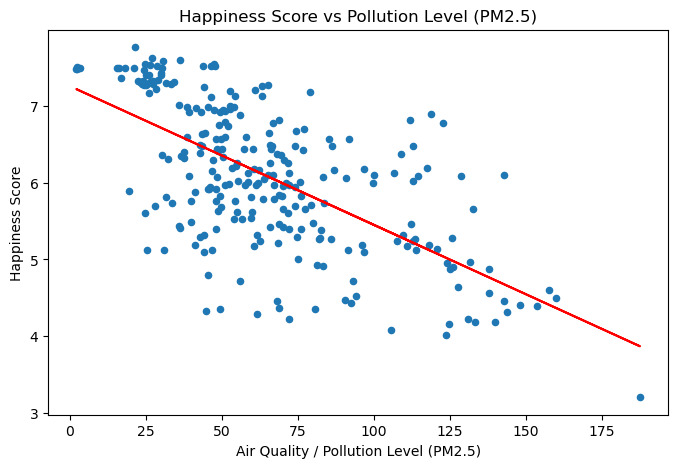

In [24]:
# Show a scatter plot of PM25 versus Score for all countries and all years
ax = analysis_df.plot.scatter(x='PM25',y='Score', figsize=(8,5))

ax.set_ylabel('Happiness Score')
ax.set_xlabel('Air Quality / Pollution Level (PM2.5)')
ax.set_title('Happiness Score vs Pollution Level (PM2.5)')
# Create a linear regression model based on the PM25 and Happiness Rank data
x_data = analysis_df['PM25']
y_data = analysis_df['Score']
[slope, intercept, rvalue, pvalue, stdeve] = stats.linregress(x_data,y_data)
print(f"R-value: {rvalue:.2f}")
print(f"Linear model: [Rank] = {slope:.4f} * [PM25] + {intercept:.2f}")

y_reg = slope*x_data+intercept
plt.plot(x_data,y_reg,'r')

#save as graph as PNG file:
plt.savefig('Images/Happiness_ScatterPlot_Score.png', format='png')

# Show plot
plt.show()

### Analysis note:  
When examining the relationship between the Happiness Score and a country's Air Quality (PM2.5 levels), we again observe a similar pattern. This time, it manifests as a <span style="color:red;"><b>moderate negative correlation</b></span>, as evidenced by the R-Value of -0.64. Through this graph, we can discern that as pollution levels increase along the x-axis (PM2.5 values), the Happiness Score of a country declines on the y-axis.

The two scatter plots above indicate that a higher PM2.5 value, indicating poorer air quality, seems to negatively impact a country's Happiness Score and overall Ranking. 



### Graph the average Air Quality(PM2.5 value) across the top and bottom ranked countries
**Top Ranked Countries** will be any country that has achieved a Happiness Rank of <=10 on any given year  

**Bottom Ranked Countries** will be any country that returned a Happiness Rank of >=92 on any given year  
      
This returns 42 top performing countries and 42 bottom performing countries in each new dataframe - ensuring we compare the same amount of data points across top and bottom countries.    

In [25]:
top_countries_df = analysis_df.loc[analysis_df['Rank'] <= 10]
top_countries_df = top_countries_df.sort_values('Rank')

top_countries_df.count()

Country    42
Year       42
PM25       42
Rank       42
Score      42
dtype: int64

In [26]:
bottom_countries_df = analysis_df.loc[analysis_df['Rank'] >=92]
bottom_countries_df = bottom_countries_df.sort_values('Rank')

bottom_countries_df.count()

Country    42
Year       42
PM25       42
Rank       42
Score      42
dtype: int64

In [27]:
# Calculate the PM25 Mean across bottom performing countries
bottom_mean = bottom_countries_df['PM25'].mean()
print(f'The mean PM2.5 air quality value across the bottom ranked countries is {bottom_mean:.1f}')

The mean PM2.5 air quality value across the bottom ranked countries is 106.3


In [28]:
# Calculate the PM25 Mean across top performing countries
top_mean = top_countries_df['PM25'].mean()
print(f'The mean PM2.5 air quality value across the top ranked countries is {top_mean:.1f}')

The mean PM2.5 air quality value across the top ranked countries is 26.0


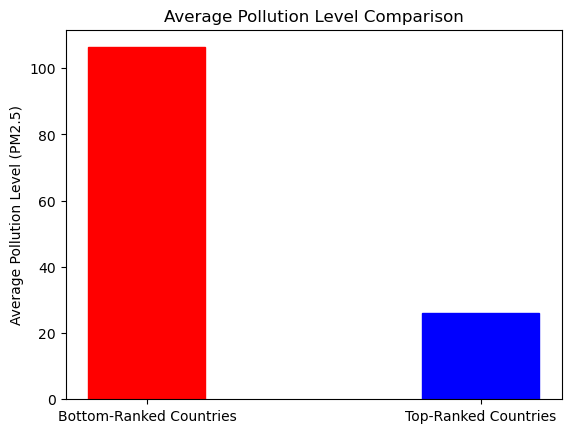

In [29]:
# Create a bar plot to viisualise the average PM25 values
labels = ['Bottom-Ranked Countries', 'Top-Ranked Countries']
mean_values = [bottom_mean, top_mean]

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects = ax.bar(x, mean_values, width)

# Set the color of the bars
rects[0].set_color('red')  # Bottom Ranked Countries
rects[1].set_color('blue')  # Top Ranked Countries

ax.set_ylabel('Average Pollution Level (PM2.5)')
ax.set_title('Average Pollution Level Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.savefig('Images/Happiness_Average_Pollution_Comparison.png', format='png')

plt.show()


### Analysis Note:  
The above graph shows that the average PM2.5 value across the **bottom-ranked countries is high at a PM2.5 value of 106**. Conversely the **top-ranked countries have a mean PM2.5 value of 26** which indicates less pollution. 

Reminder that the classification of PM2.5 concentrations may vary slightly between different countries or organisations, but in general, air quality guidelines commonly categorize PM2.5 concentrations as follows:

**Good:** 0-12   
**Moderate:** 12.1 - 35.4   
**Unhealthy for Sensitive Groups:** 35.5 - 55.4   
**Unhealthy:** 55.5 - 150.4   
**Very Unhealthy:** 150.5 - 250.4   
**Hazardous:** 250.5+ 
  
Based on these ranges, a PM2.5 value of 106 falls within the "Unhealthy" category. The top-ranked countries have a mean PM2.5 value of 26 which falls into the "Moderate" category.   

The above graph further indicates that there is a discernible relationship between a country's air quality and where they place on the Happiness Index Ranking. 


### Scatter Plot to show all Air Quality (PM2.5) values for the top and bottom ranked countries. 

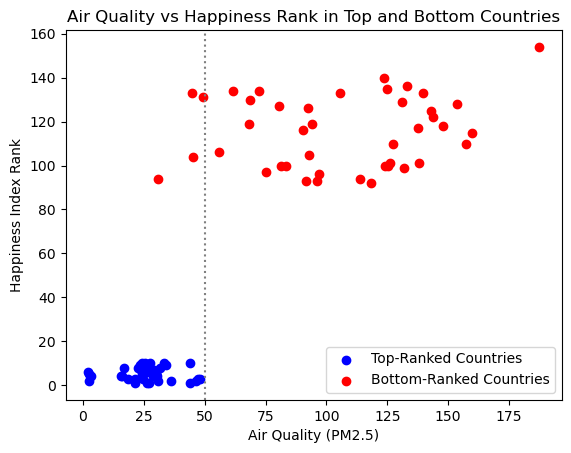

In [30]:
# Looking at the top countries and bottom countries per above
# Create a scatter plot to visualise the two ends of the spectrum
plt.scatter(top_countries_df['PM25'], top_countries_df['Rank'], color='blue', label='Top-Ranked Countries')

# Create a scatter plot of the bottom countries
plt.scatter(bottom_countries_df['PM25'], bottom_countries_df['Rank'], color='red', label='Bottom-Ranked Countries')

# Add a title and labels to the axes
plt.title('Air Quality vs Happiness Rank in Top and Bottom Countries')
plt.ylabel('Happiness Index Rank')
plt.xlabel('Air Quality (PM2.5)')

# Add a dotted vertical line at x=50 to further highlight the divide
plt.axvline(x=50, color='gray', linestyle='dotted')

# Add a legend
plt.legend()

plt.savefig('Images/ScatterTopBottomComparison.png', format='png')

#Show the plot
plt.show()

### Analysis Note:  

The above scatter plot further visualises the divide between top-ranked and bottom-ranked countries when looking at their air quality values.  

There's a clear difference with the top-ranked countries having a PM2.5 value < 50, whereas bottom-ranked countries are predominately > 50 for their PM2.5 value.  

This is visualised above using the dotted line at a PM2.5 value of 50.  

# **Conclusion:**
## _Does air quality have a significant impact on the happiness index of a country?_


Our above investigation into annual air quality data and matching the relevant annual Happiness Index Ranking data has provided some insight into possible relationships between the two.  

We can conclude that there is a moderate positive correlation between a country's Happiness Ranking and their air quality based on the PM2.5 value. As PM2.5 (pollution) gets worse, the happiness ranking tends to decline. This suggests that higher PM2.5 values are associated with lower rankings on the Happiness Index. 

This relationship is further explored using the Happiness Score, yielding similar outcomes. Higher PM2.5 values appear to negatively impact a country's Happiness Score. 

While it is important to note that air quality is not the sole determinant of a country's ranking or a significantly impactful factor based on this single metric, we can infer a relationship between air quality and the happiness index.

## _Can we see a clear difference between the top and bottom ranked countries?_

Diving deeper into the top-ranked and bottom-ranked countries on the Happiness Index has revealed a relationship between PM2.5 values and country rankings.
We can clearly observe that top-ranked countries, on average, exhibit lower PM2.5 values (indicative of less pollution), while bottom-ranked countries, on average, exhibit higher PM2.5 values (indicative of higher pollution).

**Limitations:**
It's important to consider the limitations when comparing just these two sets of data. The Happiness Ranking Index is compiled using multiple data sources, including GDP, Social Support, Life Expectancy, Freedom to Make life Choices, Generosity, Perceptions of Corruption, and self-reported Life Satisfaction. These are the key drivers of the Happiness Score and Ranking system, and it is not solely dependent on a single metric.

**Summary of major findings and implications:**

The analysis indicates a moderate positive correlation between air quality (measured by PM2.5) and a country's Happiness Ranking, suggesting that higher levels of pollution are associated with lower happiness rankings. This finding emphasises the importance of addressing air pollution as a potential contributor to overall well-being.

**Next steps and further research:**

To further explore the impact of air quality on a country's happiness index, it is important to consider additional variables and conduct more comprehensive analyses. Future research could involve examining the interactions between air quality, socioeconomic factors, and specific policy interventions to gain deeper insights into the relationship. Additionally, investigating the long-term effects of air quality improvements on happiness rankings and exploring regional variations could provide a more nuanced understanding of the subject.